In [173]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

In [174]:
df = pd.read_csv("seismic-bumps.csv")

In [175]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,hazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


## Feature preprocessing (light)

In [176]:
#remove useless variables from the dataset
column2drop = ['seismoacoustic', 'gdenergy', 'gdpuls', 'hazard','nbumps2', 'nbumps3', 'nbumps4', 'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89', 'energy', 'maxenergy']
df.drop(column2drop, axis=1, inplace=True)

In [177]:
df.head()

,seismic,shift,genergy,gpuls,nbumps,class
0,a,N,15180,48,0,0
1,a,N,14720,33,1,0
2,a,N,8050,30,0,0
3,a,N,28820,171,1,0
4,a,N,12640,57,0,0


In [178]:
###### Lecture Pipeline ######
# you can/have to modify the order for your project,
# e.g. hyperparameter tuning before evaluating a decision tree

# Oversampling
from imblearn.over_sampling import RandomOverSampler

# Hold-out
from sklearn.model_selection import train_test_split

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Optional: KNN
from sklearn.neighbors import KNeighborsClassifier

##### Decision Tree Visualization ###
from sklearn import tree # export_graphviz() method
import pydotplus # viz stuff
from IPython.display import Image # viz stuff
####################################

######## Evaluation #######
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Optional: baseline comparison
from sklearn.dummy import DummyClassifier
###########################

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# cross-validation
from sklearn.model_selection import cross_val_score

In [179]:
# Printing categorical first 5 values before pre-processing

print("sesmic's first 5 values: ", df['seismic'].values[:5])
print("shift's first 5 values: ", df['shift'].values[:5])

sesmic's first 5 values:  ['a' 'a' 'a' 'a' 'a']
shift's first 5 values:  ['N' 'N' 'N' 'N' 'N']


In [180]:
# Transform categorical attributes ('seismic' and 'shift') into numerical ones 

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['seismic'] = le.fit_transform(df['seismic'])
df['shift'] = le.fit_transform(df['shift'])

In [181]:
# Printing categorical first 5 values after pre-processing

print("sesmic's first 5 values: ", df['seismic'].values[:5])
print("shift's first 5 values: ", df['shift'].values[:5])

sesmic's first 5 values:  [0 0 0 0 0]
shift's first 5 values:  [0 0 0 0 0]


## APPLYING CLASSIFICATION

In [182]:
# Spliting dataset into training-set and test-set using HOLD-OUT method

attributes = [col for col in df.columns if col != 'class']
X = df[attributes].values
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [183]:
# Printing the shape of dataset, training-set and test-set ([number_of_rows], [number_of_columns])

df.shape, X_train.shape, X_test.shape

((2584, 6), (1808, 5), (776, 5))

In [184]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1689, 1: 1689})


In [335]:
# Applying the classification algorithm with some parameters

clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=None,
                             min_samples_split=10,
                             min_samples_leaf=5,
                            )

clf.fit(X_res, y_res)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5,
                       min_samples_split=10)

In [336]:
param_list = {'max_depth': [None] + [2, 3, 4],
             'min_samples_split': [2, 5, 10, 20],
             'min_samples_leaf': [1, 5, 10, 20]
             }

grid_search = GridSearchCV(clf, param_grid=param_list, scoring='recall')
grid_search.fit(X, y)

res = grid_search.cv_results_


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.265 (std: 0.299)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.265 (std: 0.311)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.247 (std: 0.337)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20}



In [337]:
# Priting the attibutes in order of importance according to the classification algorithm applied

imp_dict = {attr: clf.feature_importances_[i] for i, attr in enumerate(attributes)}
imp_dict

{k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)}

{'gpuls': 0.428173569793264,
 'genergy': 0.3696778699967829,
 'nbumps': 0.18144404906125616,
 'seismic': 0.011529753857547566,
 'shift': 0.009174757291149478}

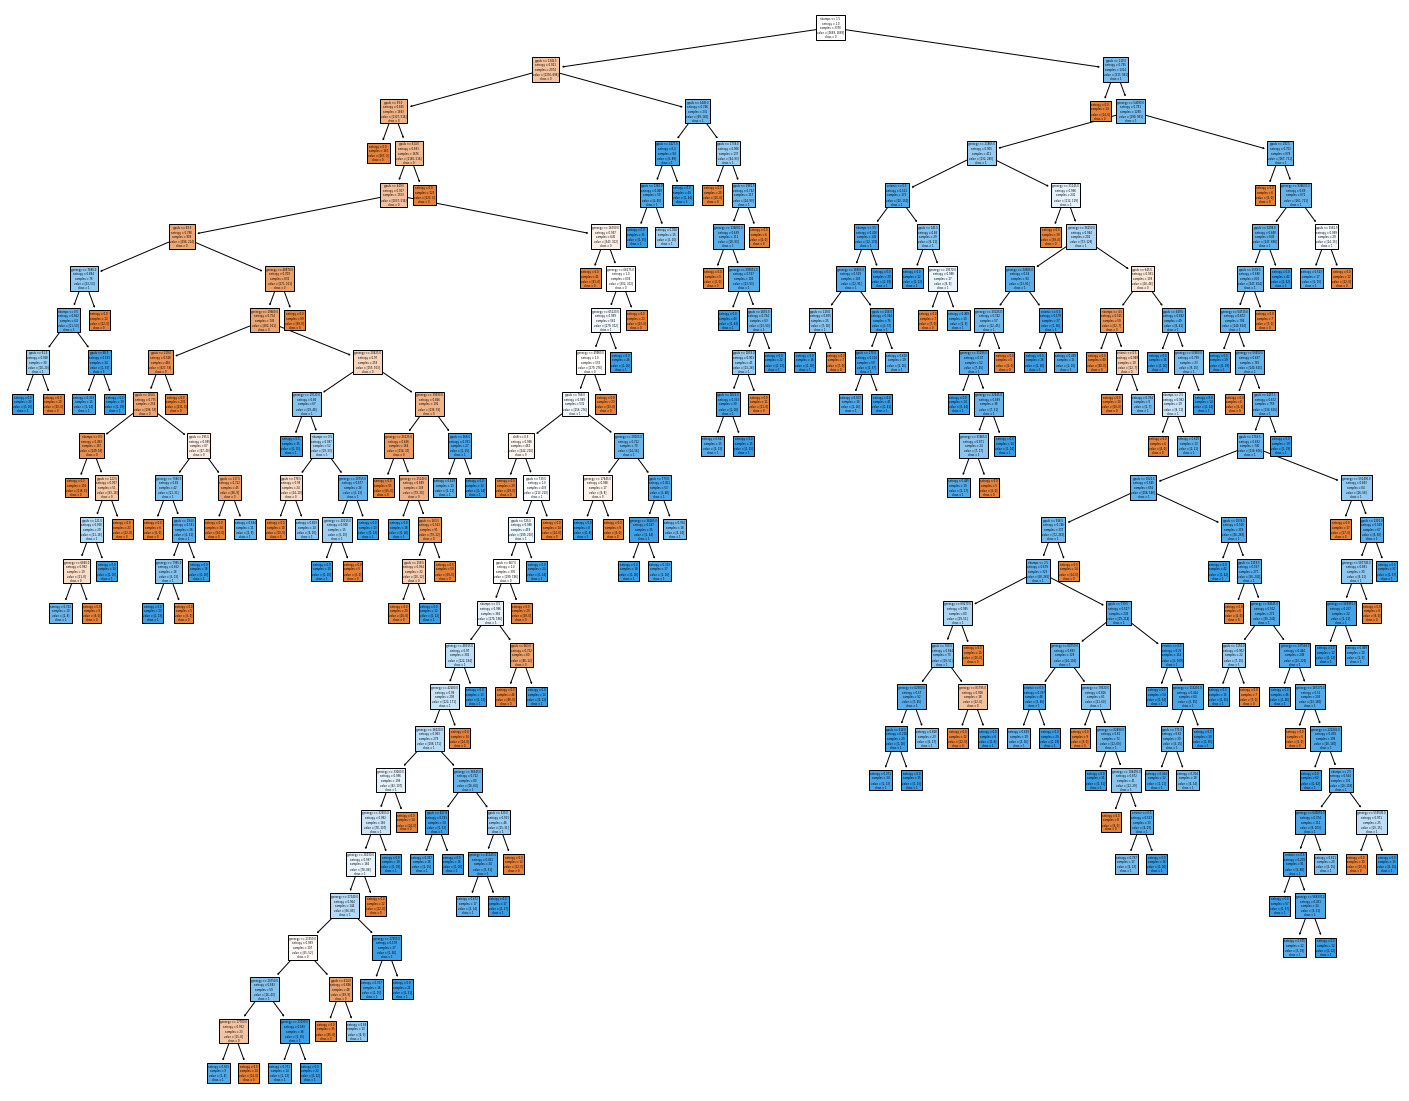

In [338]:
# Plotting the entire Decision Tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=attributes,  
                   class_names=[str(v) for v in clf.classes_],
                   filled=True)

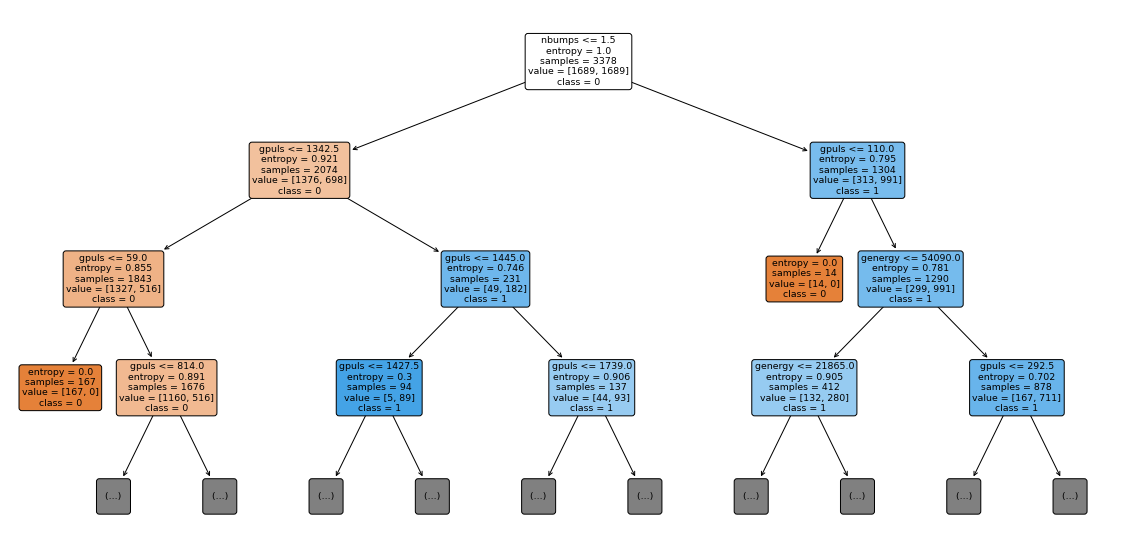

In [339]:
# Plotting only the first 3 levels of the DT

fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(clf, 
                   feature_names=attributes,  
                   class_names=[str(v) for v in clf.classes_],
                   filled=True, 
                   rounded=True,
                   max_depth=3)

## MODEL EVALUATION

In [340]:
# Applying the model to the train-set and test-set

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict( X_test )

In [341]:
# Printing the 'Accuracy' and 'F1' values for evaluate the quality of the prediction
# F1 [f1 score of negative class, f1 score positive class]

print('TRAINING-SET')
print('Accuracy', accuracy_score(y_train, y_train_pred))
print('F1', f1_score(y_train, y_train_pred, average=None),'\n')

print('TEST-SET')
print('Accuracy', accuracy_score(y_test, y_test_pred))
print('F1', f1_score(y_test, y_test_pred, average=None))

TRAINING-SET
Accuracy 0.9574115044247787
F1 [0.97667374 0.75555556] 

TEST-SET
Accuracy 0.865979381443299
F1 [0.92727273 0.14754098]


In [342]:
# Printing other evaluation indences

print('TRAINING-SET')
print( classification_report(y_train, y_train_pred), '\n\n' )

print('TEST-SET')
print( classification_report(y_test, y_test_pred) )

TRAINING-SET
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1689
           1       0.61      1.00      0.76       119

    accuracy                           0.96      1808
   macro avg       0.80      0.98      0.87      1808
weighted avg       0.97      0.96      0.96      1808
 


TEST-SET
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       725
           1       0.13      0.18      0.15        51

    accuracy                           0.87       776
   macro avg       0.53      0.55      0.54       776
weighted avg       0.89      0.87      0.88       776



In [332]:
# Printing of confusion_matrix as seen in the lecture

cf1 = confusion_matrix(y_train, y_train_pred, labels=[1,0])
cf2 = confusion_matrix(y_test, y_test_pred, labels=[1,0])


print('TRAINING-SET')
print( cf1, '\n')
print('TEST-SET')
print( cf2 )


TRAINING-SET
[[ 114    5]
 [ 281 1408]] 

TEST-SET
[[ 21  30]
 [128 597]]


In [333]:
# TP, FN, FP, TN
print('TRAINING-SET: ', cf1[0][0], cf1[0][1], cf1[1][0], cf1[1][1])
print('TEST-SET:     ', cf2[0][0], cf2[0][1], cf2[1][0], cf2[1][1])

TRAINING-SET:  114 5 281 1408
TEST-SET:      21 30 128 597


In [300]:
cf1 = confusion_matrix(y_train, y_train_pred, labels=[1,0], normalize='all')
cf2 = confusion_matrix(y_train, y_train_pred, labels=[1,0], normalize='all')

print('TRAINING-SET')
print( cf1, '\n')
print('TEST-SET')
print( cf2 )

TRAINING-SET
[[0.06581858 0.        ]
 [0.04314159 0.89103982]] 

TEST-SET
[[0.06581858 0.        ]
 [0.04314159 0.89103982]]


In [240]:
# Here the output is not a single value, but pair of value 
# [probability to belong to class '0', prob. to belong to class to belong to class '1']

y_score = clf.predict_proba(X_test)
y_score[:6]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [241]:
# Printing of AUC value (aka Area under the ROC)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

0.5702772143340095


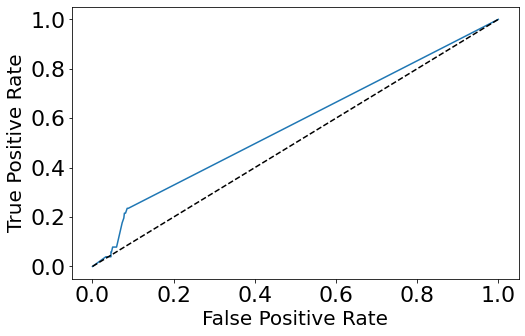

In [242]:
# Plotting of ROC Curve

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [221]:
clfk = KNeighborsClassifier(n_neighbors=5)
clfk.fit(X_res, y_res)

KNeighborsClassifier()

In [222]:
#prediction
yk_pred = clfk.predict(X_test)

In [224]:
print('Accuracy', accuracy_score(y_test, yk_pred))
print('F1', f1_score(y_test, yk_pred, average=None))

Accuracy 0.7770618556701031
F1 [0.87288758 0.09424084]


In [225]:
# Printing other evaluation indences
print( classification_report(y_test, yk_pred) )

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       725
           1       0.06      0.18      0.09        51

    accuracy                           0.78       776
   macro avg       0.50      0.50      0.48       776
weighted avg       0.88      0.78      0.82       776



In [226]:
# Applying the model to the test-set (default threshold = 0.5)
yk_pred = clfk.predict( X_test )
yk_pred[:5]

array([0, 1, 0, 0, 0])

In [227]:
# Here the output is not a single value, but pair of value 
# [probability to belong to class '0', prob. to belong to class to belong to class '1']

yk_score = clfk.predict_proba(X_test)
yk_score[:6]

array([[0.8, 0.2],
       [0.2, 0.8],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [228]:
# Printing of AUC value (aka Area under the ROC)
fpr, tpr, th = roc_curve(y_test, yk_score[:,1])

In [229]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.5284110885733604


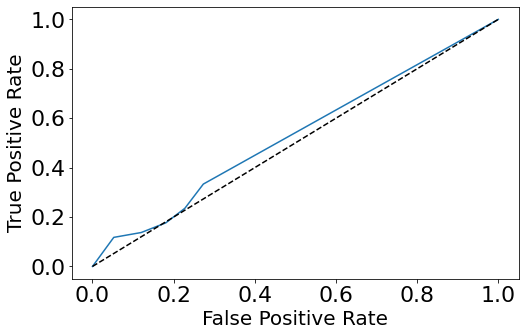

In [230]:
# Plotting of ROC Curve

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [231]:
cf = confusion_matrix(y_test, yk_pred, labels=[1,0])
cf

array([[  9,  42],
       [131, 594]])